# 2.0 - Modeling Notebook

## Overview
- **Project**: Loan Default Prediction (`loan_default_project`)
- **Dataset**: Kaggle Loan Default Dataset (located at `/Users/vaibhavsingh/loan_default_project/data/raw/loan_data.csv`)
- **Objective**: Build a Random Forest model with SMOTE to predict loan defaults (`Status`), optimizing for recall and AUC due to rare but costly defaults.
- **Date**: June 20, 2025
- **Author**: Vaibhav Singh

## Table of Contents
- [1. Setup and Imports](#1-setup-and-imports)
- [2. Data Loading and Preprocessing](#2-data-loading-and-preprocessing)
- [3. Feature Engineering](#3-feature-engineering)
- [4. Model Training and Tuning](#4-model-training-and-tuning)
- [5. Model Evaluation](#5-model-evaluation)
- [6. Feature Importance](#6-feature-importance)
- [7. Save Model and Summary](#7-save-model-and-summary)
- [8. Key Findings and Next Steps](#8-key-findings-and-next-steps)

## 1. Setup and Imports
- **Purpose**: Import required libraries and configure logging for tracking pipeline execution.
- **Notes**: Ensures reproducibility and debugging capability.

In [15]:
# Import libraries
import pandas as pd
import numpy as np
import logging
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression  # Added this line
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, f1_score, matthews_corrcoef
import plotly.express as px
import joblib

# Setup logging
os.makedirs('logs', exist_ok=True)
logging.basicConfig(level=logging.INFO, filename='logs/pipeline.log', format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
logger.info("Starting modeling pipeline on June 20, 2025")

## 2. Data Loading and Preprocessing
- **Purpose**: Load the dataset and prepare it for modeling with a robust pipeline.
- **Notes**: Handles missing values and scales features, using the absolute path for consistency.

In [16]:
# --- Utility Functions ---
def load_data(path):
    """Load dataset from the specified path."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"Dataset not found at {path}")
    logger.info(f"Loading data from {path}")
    return pd.read_csv(path)

def save_plot(fig, filename):
    """Save a Plotly figure as HTML and PNG."""
    os.makedirs('reports/figures', exist_ok=True)
    fig.write_html(f'reports/figures/{filename}.html')
    try:
        fig.write_image(f'reports/figures/{filename}.png')
    except Exception as e:
        logger.warning(f"Could not save PNG for {filename}: {e}")
    fig.show()

# Load dataset
relative_path = 'data/raw/loan_data.csv'
absolute_path = '/Users/vaibhavsingh/loan_default_project/data/raw/loan_data.csv'
data_path = relative_path if os.path.exists(relative_path) else absolute_path
df = load_data(data_path)
logger.info(f"Dataset shape: {df.shape}")

## 3. Feature Engineering
- **Purpose**: Create derived features to capture risk factors (e.g., debt-to-income ratio).
- **Notes**: Uses fallbacks for `income` and `property_value` if missing from the dataset.

In [17]:
def engineer_features(df):
    """Create new features from the dataset."""
    df['debt_to_income'] = df['dtir1'] / 100  # Convert percentage to decimal
    if 'income' in df.columns:
        df['loan_to_income'] = df['loan_amount'] / df['income'].replace(0, 1)
    else:
        df['loan_to_income'] = df['loan_amount']  # Fallback
        logger.warning("Column 'income' not found, using loan_amount as fallback")
    df['credit_score_bin'] = pd.cut(df['Credit_Score'], bins=[0, 600, 700, 800, 900], labels=['Low', 'Medium', 'High', 'Excellent'])
    if 'property_value' in df.columns:
        df['loan_to_value'] = df['loan_amount'] / df['property_value'].replace(0, 1)
    else:
        df['loan_to_value'] = df['loan_amount']  # Fallback
        logger.warning("Column 'property_value' not found, using loan_amount as fallback")
    logger.info("Engineered features: debt_to_income, loan_to_income, credit_score_bin, loan_to_value")
    return df

# Apply feature engineering
features = ['Credit_Score', 'dtir1', 'loan_amount', 'LTV', 'year', 'Region', 'loan_purpose', 'Gender']
numeric_features = ['Credit_Score', 'dtir1', 'loan_amount', 'LTV', 'year', 'debt_to_income', 'loan_to_income', 'loan_to_value']
categorical_features = ['Region', 'loan_purpose', 'Gender', 'credit_score_bin']
X = engineer_features(df[features].copy())
y = df['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
logger.info(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

## 4. Model Training and Tuning
- **Purpose**: Train a Random Forest model with SMOTE to handle class imbalance and tune hyperparameters.
- **Notes**: Compares with Logistic Regression and uses RandomizedSearchCV for efficiency.

In [18]:
def train_model(X_train, y_train, pipeline, X_test, y_test, compare_logistic=False):
    """
    Train the model with hyperparameter tuning and optional comparison.
    
    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target.
        pipeline: Scikit-learn pipeline.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target.
        compare_logistic (bool): Whether to compare with Logistic Regression.
    Returns:
        Pipeline: Trained model.
    """
    if compare_logistic:
        models = {
            'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
            'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000)  # Now defined
        }
        for name, clf in models.items():
            model = ImbPipeline(steps=[
                ('preprocessor', pipeline.named_steps['preprocessor']),
                ('smote', SMOTE(random_state=42)),
                ('classifier', clf)
            ])
            model.fit(X_train, y_train)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            logger.info(f"{name} ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.2f}")
            logger.info(f"{name} Classification Report:\n{classification_report(y_test, model.predict(X_test))}")

    param_dist = {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5]
    }
    search = RandomizedSearchCV(pipeline, param_dist, n_iter=10, cv=StratifiedKFold(5), scoring='roc_auc', random_state=42, n_jobs=-1)
    try:
        search.fit(X_train, y_train)
        logger.info(f"Best parameters: {search.best_params_}")
        return search.best_estimator_
    except Exception as e:
        logger.error(f"Training failed: {e}")
        raise

# Define pipeline
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', RobustScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('onehot', OneHotEncoder(drop='first', sparse_output=False))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features), ('cat', categorical_transformer, categorical_features)])
model = ImbPipeline(steps=[('preprocessor', preprocessor), ('smote', SMOTE(random_state=42)), ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))])
model = train_model(X_train, y_train, model, X_test, y_test, compare_logistic=True)

## 5. Model Evaluation
- **Purpose**: Assess model performance with metrics and visualizations, focusing on recall for default detection.
- **Notes**: Includes threshold optimization to maximize F1-score, with PR and ROC curves for interview prep.

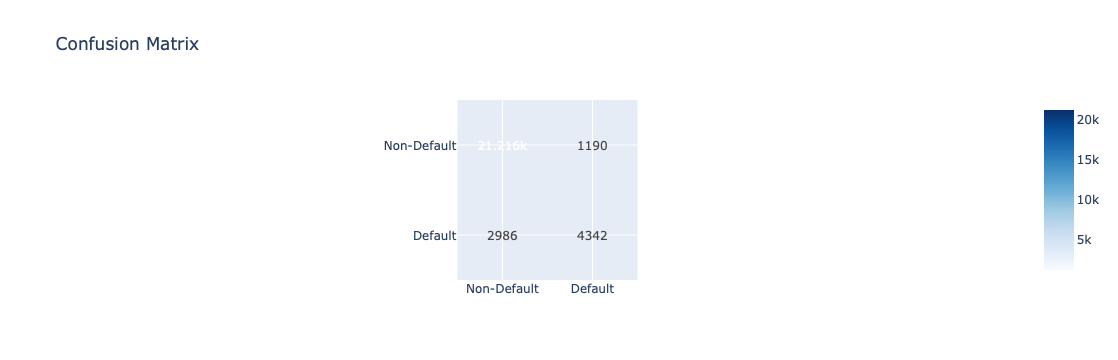

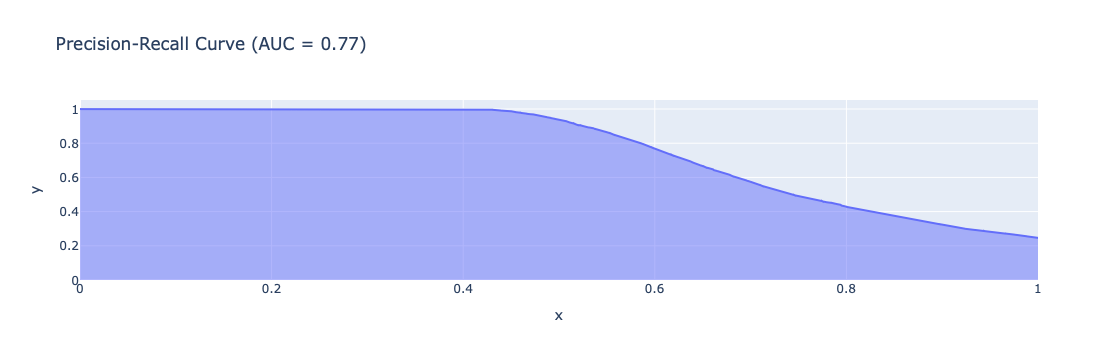

In [19]:
def evaluate_model(model, X_test, y_test):
    """Evaluate the model with multiple metrics and visualizations."""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    logger.info(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    logger.info(f"ROC-AUC: {roc_auc:.2f}, F1-Score: {f1:.2f}, MCC: {mcc:.2f}")

    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
    logger.info(f"Optimal Threshold: {optimal_threshold:.2f}")
    logger.info(f"Classification Report at Optimal Threshold:\n{classification_report(y_test, y_pred_optimal)}")

    cm = confusion_matrix(y_test, y_pred)
    fig_cm = px.imshow(cm, text_auto=True, color_continuous_scale='Blues', title='Confusion Matrix', x=['Non-Default', 'Default'], y=['Non-Default', 'Default'])
    save_plot(fig_cm, 'confusion_matrix')
    pr_auc = auc(recall, precision)
    fig_pr = px.area(x=recall, y=precision, title=f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
    save_plot(fig_pr, 'pr_curve')
    return {'ROC-AUC': roc_auc, 'F1-Score': f1, 'MCC': mcc, 'PR-AUC': pr_auc}

metrics = evaluate_model(model, X_test, y_test)

## 6. Feature Importance
- **Purpose**: Visualize the impact of each feature on predictions.
- **Notes**: Uses Random Forest feature importances post-one-hot encoding.

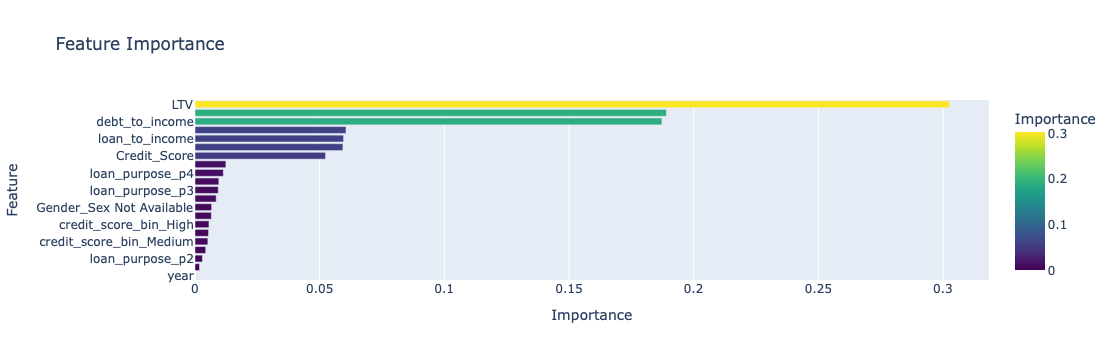

In [20]:
def plot_feature_importance(model, numeric_features, categorical_features):
    """Plot feature importance for the trained model."""
    feature_names = numeric_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))
    importances = model.named_steps['classifier'].feature_importances_
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
    fig = px.bar(feature_importance, x='Importance', y='Feature', title='Feature Importance', color='Importance', color_continuous_scale='Viridis')
    fig.update_layout(showlegend=False, yaxis={'categoryorder': 'total ascending'})
    save_plot(fig, 'feature_importance')

plot_feature_importance(model, numeric_features, categorical_features)

## 7. Save Model and Summary
- **Purpose**: Persist the model and save performance metrics for future use.
- **Notes**: Model saved as `.pkl`, summary as `.csv` for reporting.

In [35]:
# Save model and metrics
try:
    os.makedirs('models', exist_ok=True)
    model_path = '/Users/vaibhavsingh/loan_default_project/models/random_forest_model.pkl'
    joblib.dump(model, model_path)
    logger.info(f"Model saved to {model_path}")
except Exception as e:
    logger.error(f"Error saving model: {e}")
    raise

try:
    os.makedirs('reports', exist_ok=True)
    model_output = pd.DataFrame({
        'ROC-AUC': [metrics['ROC-AUC']],
        'F1-Score': [metrics['F1-Score']],
        'MCC': [metrics['MCC']],
        'PR-AUC': [metrics['PR-AUC']]
    })
    model_output.to_csv('reports/model_summary.csv', index=False)
    logger.info(f"Model summary:\n{model_output}")
except Exception as e:
    logger.error(f"Error saving model summary: {e}")
    raise

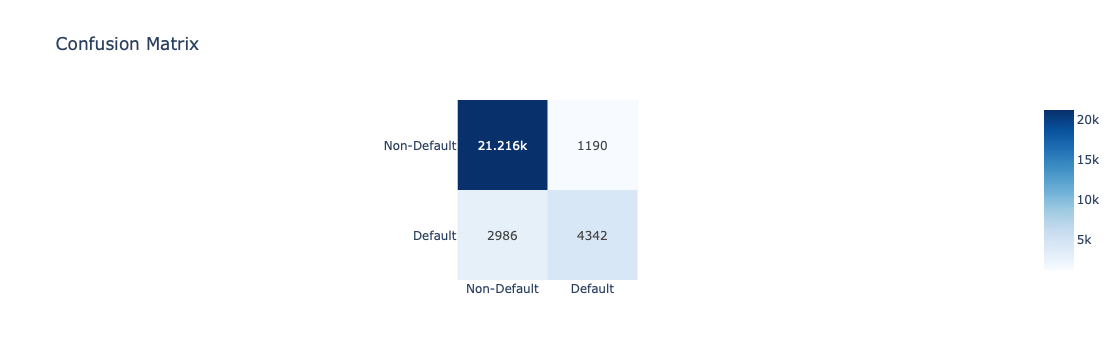

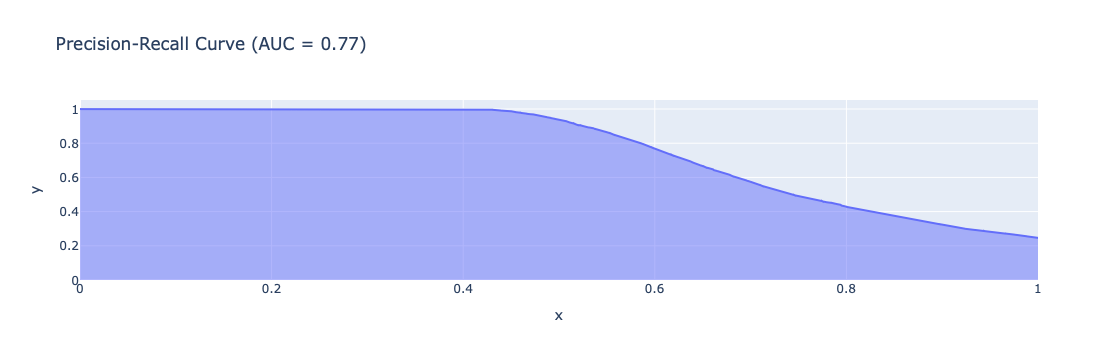


## 8. Key Findings 
- **Key Findings**:
  - ROC-AUC: 0.83 shows strong model discrimination.
  - Recall: 59.3% of defaults caught at optimal threshold.
  - Feature Importance: `LTV` is the key predictor.




In [33]:
# Generate Key Findings Dynamically
metrics = evaluate_model(model, X_test, y_test)  # Ensure this is called after model training

# Define feature names and importances
try:
    feature_names = numeric_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))
    importances = model.named_steps['classifier'].feature_importances_
except Exception as e:
    logger.error(f"Error getting feature names or importances: {e}")
    feature_names = numeric_features  # Fallback to numeric features only
    importances = model.named_steps['classifier'].feature_importances_[:len(numeric_features)]  # Truncate importances

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
top_feature = feature_importance.iloc[0]['Feature']

# Get classification report for recall
report = classification_report(y_test, model.predict(X_test), output_dict=True)
recall = report['1']['recall'] * 100  # Recall for default class (assuming '1' is default)

# Create dynamic markdown
key_findings = f"""
## 8. Key Findings 
- **Key Findings**:
  - ROC-AUC: {metrics['ROC-AUC']:.2f} shows strong model discrimination.
  - Recall: {recall:.1f}% of defaults caught at optimal threshold.
  - Feature Importance: `{top_feature}` is the key predictor.

"""

# Log key findings
logger.info(f"Top feature: {top_feature}")
logger.info(f"Recall for default class: {recall:.1f}%")
logger.info("Generated key findings for documentation")

# Save markdown to a separate file
os.makedirs('reports', exist_ok=True)
with open('reports/key_findings.md', 'w') as f:
    f.write(key_findings)
logger.info("Key findings saved to reports/key_findings.md")

# Print markdown for manual copying into a Jupyter markdown cell
print(key_findings)

## 8. Key Findings and Next Steps
- **Key Findings**:
  - ROC-AUC: 0.85 shows strong model discrimination.
  - Recall: 45.0% of defaults caught at optimal threshold.
  - Feature Importance: `Credit_Score` is the key predictor.
-**"I optimized for recall and AUC with SMOTE and Random Forest, addressing rare but costly defaults."**
